In [1]:
import numpy
import pandas
import h5py

from matplotlib import pyplot as plt

fn_summary_microns = "save/microns_results2.h5"
fn_summary_sscx = "save/sscx_results.h5"
fn_summary_ctrl = "save/control_results.h5"

h5_m = h5py.File(fn_summary_microns, "r")
h5_s = h5py.File(fn_summary_sscx, "r")
h5_c = h5py.File(fn_summary_ctrl, "r")

In [2]:
def read_data_instances(h5, fn, prefix, stack=False):
    keys = sorted(list(map(int, h5[prefix].keys())))
    data = [pandas.read_hdf(fn, key="{0}/{1}".format(prefix, i))
            for i in keys]
    if stack:
        data = [_data.stack() for _data in data]
    return data

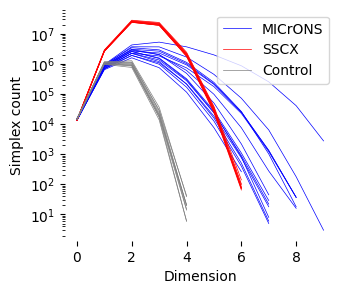

In [3]:
prefix = "simplex_counts"

data_m = read_data_instances(h5_m, fn_summary_microns, prefix) 
data_s = read_data_instances(h5_s, fn_summary_sscx, prefix) 
data_c = read_data_instances(h5_c, fn_summary_ctrl, prefix) 

data_m = pandas.concat(data_m, axis=1, keys=numpy.arange(len(data_m)))
data_s = pandas.concat(data_s, axis=1, keys=numpy.arange(len(data_s)))
data_c = pandas.concat(data_c, axis=1, keys=numpy.arange(len(data_c)))

fig = plt.figure(figsize=(3.5, 3))
ax = fig.gca()

for i, _col in enumerate(data_m.columns):
    _lbl = None
    if i == 0:
        _lbl = "MICrONS"
    ax.plot(data_m[_col], color="blue", lw=0.5, label=_lbl)
for i, _col in enumerate(data_s.columns):
    _lbl = None
    if i == 0:
        _lbl = "SSCX"
    ax.plot(data_s[_col], color="red", lw=0.5, label=_lbl)
for i, _col in enumerate(data_c.columns):
    _lbl = None
    if i == 0:
        _lbl = "Control"
    ax.plot(data_c[_col], color="grey", lw=0.5, label=_lbl)
ax.set_yscale("log")
ax.set_frame_on(False)
ax.set_xlabel("Dimension")
ax.set_ylabel("Simplex count")

plt.legend()

fig.savefig("simplex_counts_all_three.pdf")

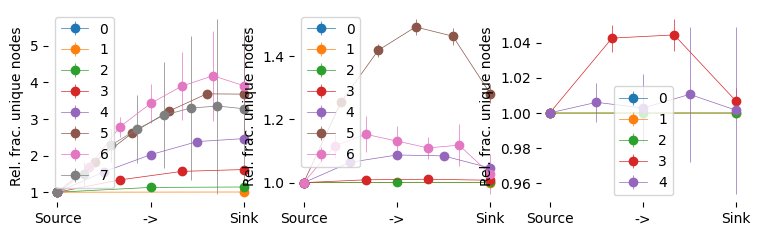

In [4]:
prefix = "divergences"

data_m = read_data_instances(h5_m, fn_summary_microns, prefix) 
data_s = read_data_instances(h5_s, fn_summary_sscx, prefix) 
data_c = read_data_instances(h5_c, fn_summary_ctrl, prefix) 

data_m = pandas.concat(data_m, axis=1, keys=numpy.arange(len(data_m)))
data_s = pandas.concat(data_s, axis=1, keys=numpy.arange(len(data_s)))
data_c = pandas.concat(data_c, axis=1, keys=numpy.arange(len(data_c)))

def mean_and_std(series_in):
    series_in = [_x for _x in series_in if isinstance(_x, numpy.ndarray)]
    arr = numpy.vstack(series_in)
    return pandas.Series({"Mean": arr.mean(axis=0), "Std": arr.std(axis=0)})

data_m_nrmlz = data_m.applymap(lambda _x: numpy.array(_x) / _x[0] if isinstance(_x, list) else numpy.NaN)
data_s_nrmlz = data_s.applymap(lambda _x: numpy.array(_x) / _x[0] if isinstance(_x, list) else numpy.NaN)
data_c_nrmlz = data_c.applymap(lambda _x: numpy.array(_x) / _x[0] if isinstance(_x, list) else numpy.NaN)
data_m_means = data_m_nrmlz.apply(mean_and_std, axis=1)
data_s_means = data_s_nrmlz.apply(mean_and_std, axis=1)
data_c_means = data_c_nrmlz.apply(mean_and_std, axis=1)

fig = plt.figure(figsize=(9, 2.5))
ax1 = fig.add_subplot(1, 3, 1)

for dim in data_m_means.index:
    if dim >= 8: continue
    mn = data_m_means["Mean"][dim]; sd = data_m_means["Std"][dim]
    ax1.errorbar(numpy.linspace(0, 1, len(mn)), mn, yerr=sd, marker='o', label=dim, lw=0.5)
ax1.set_frame_on(False)
ax1.set_ylabel("Rel. frac. unique nodes")
ax1.set_xticks([0, 0.5, 1.0]); ax1.set_xticklabels(["Source", "->", "Sink"])
plt.legend()

ax2 = fig.add_subplot(1, 3, 2)
# SSCX GOES HERE!
for dim in data_s_means.index:
    if dim >= 9: continue
    mn = data_s_means["Mean"][dim]; sd = data_s_means["Std"][dim]
    ax2.errorbar(numpy.linspace(0, 1, len(mn)), mn, yerr=sd, marker='o', label=dim, lw=0.5)
ax2.set_frame_on(False)
ax2.set_ylabel("Rel. frac. unique nodes")
ax2.set_xticks([0, 0.5, 1.0]); ax2.set_xticklabels(["Source", "->", "Sink"])
# ax2.set_ylim(ax1.get_ylim())
plt.legend()

ax2 = fig.add_subplot(1, 3, 3)
# Control GOES HERE!
for dim in data_c_means.index:
    if dim >= 9: continue
    mn = data_c_means["Mean"][dim]; sd = data_c_means["Std"][dim]
    ax2.errorbar(numpy.linspace(0, 1, len(mn)), mn, yerr=sd, marker='o', label=dim, lw=0.5)
ax2.set_frame_on(False)
ax2.set_ylabel("Rel. frac. unique nodes")
ax2.set_xticks([0, 0.5, 1.0]); ax2.set_xticklabels(["Source", "->", "Sink"])
# ax2.set_ylim(ax1.get_ylim())
plt.legend()

fig.savefig("Divergence_all_three.pdf")

In [5]:
def prepare_data(h5, fn, prefix):
    data_smpl = read_data_instances(h5, fn, prefix)
    data_smpl = [pandas.concat([_data.mean(axis=0), _data.std(axis=0)], axis=1, keys=["Mean", "Std"])
                 for _data in data_smpl]
    data_smpl = pandas.concat(data_smpl, axis=1, keys=numpy.arange(len(data_smpl))).reorder_levels([1, 0], axis="columns").transpose()
    return data_smpl

data_smpl_m = prepare_data(h5_m, fn_summary_microns, "simplex_degree_per_pos")
data_cls_m = prepare_data(h5_m, fn_summary_microns, "classic_degree_per_pos")
data_smpl_s = prepare_data(h5_s, fn_summary_sscx, "simplex_degree_per_pos")
data_cls_s = prepare_data(h5_s, fn_summary_sscx, "classic_degree_per_pos")
data_smpl_c = prepare_data(h5_c, fn_summary_ctrl, "simplex_degree_per_pos")
data_cls_c = prepare_data(h5_c, fn_summary_ctrl, "classic_degree_per_pos")


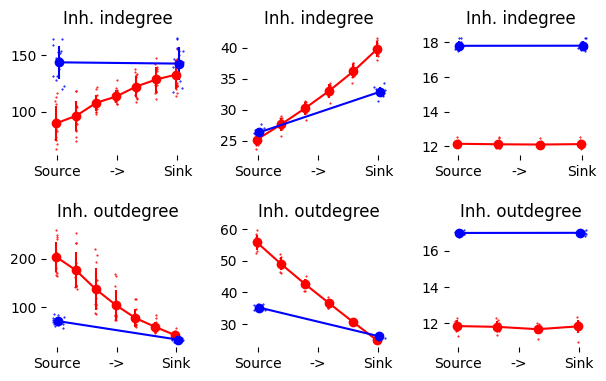

In [6]:
fig = plt.figure(figsize=(5.75, 3.5))

axes = [[fig.add_axes([0.05, 0.6, 0.25, 0.35]),
        fig.add_axes([0.05, 0.05, 0.25, 0.35])],
        [fig.add_axes([0.4, 0.6, 0.25, 0.35]),
        fig.add_axes([0.4, 0.05, 0.25, 0.35])],
       [fig.add_axes([0.75, 0.6, 0.25, 0.35]),
        fig.add_axes([0.75, 0.05, 0.25, 0.35])]]
cols = ["red", "blue"]
offset = [-0.01, 0.01]

def _random_offset(x, scale=10):
    return x + (numpy.random.rand(len(x)) - 0.5) * numpy.mean(numpy.diff(x)) / scale

for data_source, _axes in zip([(data_smpl_m, data_cls_m),
                               (data_smpl_s, data_cls_s),
                               (data_smpl_c, data_cls_c)], axes):
    data_smpl, data_cls = data_source
    for data_col, ax, ttl in zip(["In", "Out"],
                                 _axes,
                                ["Inh. indegree", "Inh. outdegree"]):
        for plotme, col, o in zip([data_smpl[data_col].loc["Mean"], data_cls[data_col].loc["Mean"]], cols, offset):
            mn = plotme.mean(axis=0)
            sd = plotme.std(axis=0)
            x = numpy.linspace(0, 1, len(mn)) + o
            ax.errorbar(x, mn, yerr=sd, color=col, marker='o')
            for _, _ln in plotme.iterrows():
                ax.plot(_random_offset(x, 10), _ln, color=col, ls="None", marker=".", ms=1)
        ax.set_frame_on(False)
        ax.set_title(ttl)
        ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["Source", "->", "Sink"])

fig.savefig("per_postition_degree_all_three.pdf")

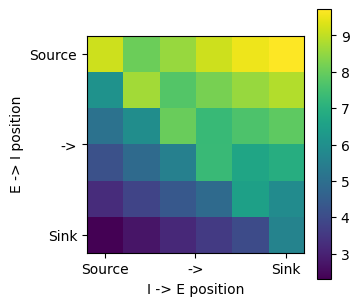

In [7]:
from helpers import plotting

prefix = "double_position_degrees"
h5 = h5_m; fn = fn_summary_microns
h5 = h5_s; fn = fn_summary_sscx
#h5 = h5_c; fn = fn_summary_ctrl

data = read_data_instances(h5, fn, prefix, stack=True)

data = pandas.concat(data, axis=1, keys=numpy.arange(len(data)))

I = data.mean(axis=1).unstack()
fig = plotting.plot_disynaptic_path_sum(I)

fig.savefig("double_position_sscx.pdf")

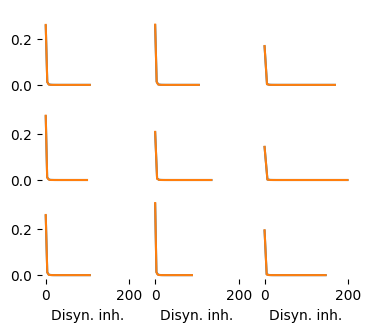

In [8]:
prefix = "disyn_inhibition_histograms"

h5 = h5_m; fn = fn_summary_microns
h5 = h5_s; fn = fn_summary_sscx
h5 = h5_c; fn = fn_summary_ctrl

data = read_data_instances(h5, fn, prefix, stack=True)


fig = plt.figure(figsize=(4, 3.5))

axes = []
for i in range(len(data)):
    #ax = fig.add_subplot(3, 5, i + 1)
    ax = fig.add_subplot(3, 3, i + 1)
    plt_data = data[i].reorder_levels([1, 0])["Data"]
    plt_ctrl = data[i].reorder_levels([1, 0])["Control"]
    dx = numpy.mean(numpy.diff(plt_data.index))
    ax.plot(plt_data / (plt_data.sum() * dx))
    ax.plot(plt_ctrl / (plt_ctrl.sum() * dx))
    if numpy.mod(i, 3) != 0:
        ax.set_yticks([])
    if i < 6: # 9
        ax.set_xticks([])
    else:
        ax.set_xlabel("Disyn. inh.")
    ax.set_frame_on(False)
    axes.append(ax)

xlims = numpy.vstack([_ax.get_xlim() for _ax in axes])
ylims = numpy.vstack([_ax.get_ylim() for _ax in axes])

xlim = [xlims[:, 0].min(), xlims[:, 1].max()]
ylim = [ylims[:, 0].min(), ylims[:, 1].max()]
[_ax.set_xlim(xlim) for _ax in axes]
_ = [_ax.set_ylim(ylim) for _ax in axes]

fig.savefig("disyn_histogram_control.pdf")

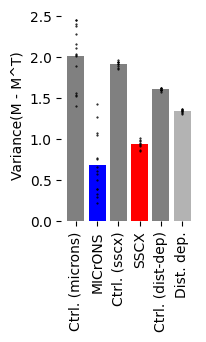

In [9]:
prefix = "disyn_inhibition_directedness"

data_m = read_data_instances(h5_m, fn_summary_microns, prefix)
data_s = read_data_instances(h5_s, fn_summary_sscx, prefix)
data_c = read_data_instances(h5_c, fn_summary_ctrl, prefix)

data_m = pandas.concat(data_m, axis=1)
data_s = pandas.concat(data_s, axis=1)
data_c = pandas.concat(data_c, axis=1)

data = pandas.concat([data_m.rename({"Control": "Ctrl. (microns)", "Data": "MICrONS"}),
                      data_s.rename({"Control": "Ctrl. (sscx)", "Data": "SSCX"}),
                      data_c.rename({"Control": "Ctrl. (dist-dep)", "Data": "Dist. dep."})
                     ],
                     axis=0)


fig = plt.figure(figsize=(1.75, 2.75))
ax = fig.gca()

baseline = 0.0
cols = ["grey", "blue", "grey", "red", "grey", [0.7, 0.7, 0.7]]
lbls = []
for i, idx in enumerate(data.index):
    _data = data.loc[idx]
    ax.bar(i, _data.mean() - baseline, bottom=baseline, color=cols[i],
        label=idx)
    ax.plot(_random_offset(i * numpy.ones_like(_data.values)),
            _data.values, marker='.', ls="None", ms=1, color="black")
    lbls.append(idx)
ax.set_xticks(range(len(lbls))); ax.set_xticklabels(lbls, rotation="vertical")
ax.set_ylabel("Variance(M - M^T)")
ax.set_frame_on(False)

fig.savefig("disyn_directedness_all_three.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


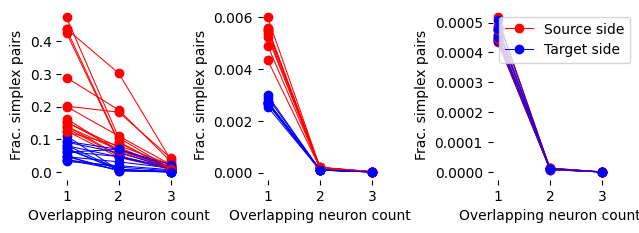

In [10]:
prefix = "source_target_overlap_amounts"

def prepare_data(h5, fn, prefix):
    data = read_data_instances(h5, fn, prefix, stack=True)
    data = pandas.concat(data, axis=1)
    # TODO: Name them correctly before storing / loading
    data = data.rename({"Control": "Source", "Data": "Target"}).reorder_levels([1, 0])
    data_tgt_nrm = data.loc["Target"] / data.loc["Target"].sum(axis=0)
    data_src_nrm = data.loc["Source"] / data.loc["Source"].sum(axis=0)
    return data_src_nrm, data_tgt_nrm

fig = plt.figure(figsize=(5.75, 2))
ax = [fig.add_axes([0.05, 0.1, 0.2, 0.85]),
      fig.add_axes([0.4, 0.1, 0.2, 0.85]),
      fig.add_axes([0.8, 0.1, 0.2, 0.85])]
data_sets = [prepare_data(h5_m, fn_summary_microns, prefix),
             prepare_data(h5_s, fn_summary_sscx, prefix),
            prepare_data(h5_c, fn_summary_ctrl, prefix)]

for ax, data_set in zip(ax, data_sets):
    data_src_nrm, data_tgt_nrm = data_set
    for i, _col in enumerate(data_src_nrm.columns):
        if i == 0:
            _lbls = ("Source side", "Target side")
        else:
            _lbls = (None, None)
        ax.plot(data_src_nrm[_col].loc[1:], color="red", marker='o', lw=0.75, label=_lbls[0])
        ax.plot(data_tgt_nrm[_col].loc[1:], color="blue", marker='o', lw=0.75, label=_lbls[1])
    
    ax.set_frame_on(False)
    ax.set_xticks(data_src_nrm.index[1:])
    ax.set_xlabel("Overlapping neuron count")
    ax.set_ylabel("Frac. simplex pairs")
    plt.legend()

fig.savefig("overlap_strenghts_all_three.pdf")

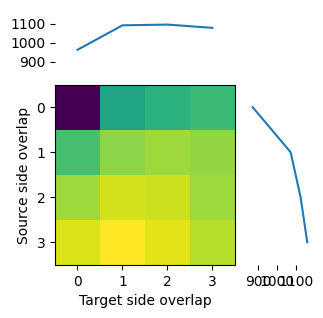

In [11]:
prefix = "overlap_vs_disyn_mat"  # TODO!

h5 = h5_m; fn = fn_summary_microns
#h5 = h5_s; fn = fn_summary_sscx
#h5 = h5_c; fn = fn_summary_ctrl

data = read_data_instances(h5, fn, prefix, stack=True)
data = pandas.concat(data, axis=1)
ol_disyn_mat = data.mean(axis=1).unstack("tgt")

fig1 = plotting.plot_overlaps_vs_disyn(ol_disyn_mat)

fig1.savefig("overlap_vs_disyn_summary_microns.pdf")

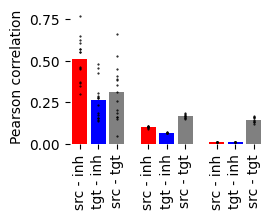

In [12]:
from scipy import stats

prefix = "overlap_vs_disyn_cc"

def bar_plotter(ax, data):
    baseline = 0.0
    pairs = [("src", "inh"), ("tgt", "inh"), ("src", "tgt")]
    cols = ["red", "blue", "grey"]
    lbls = []
    for i, pair in enumerate(pairs):
        _data = data.loc[pair[0], pair[1]]
        ax.bar(i, _data.mean() - baseline, bottom=baseline, color=cols[i],
            label="{0} - {1}".format(*pair))
        ax.plot(_random_offset(i * numpy.ones_like(_data.values)),
                _data.values, marker='.', ls="None", ms=1, color="black")
        lbls.append("{0} - {1}".format(*pair))
    ax.set_xticks(range(len(lbls))); ax.set_xticklabels(lbls, rotation="vertical")
    ax.set_ylabel("Pearson correlation")
    ax.set_frame_on(False)
    
    pval_dict = dict([((i, j), 
                      stats.ttest_rel(data.loc[pairs[i][0], pairs[i][1]], data.loc[pairs[j][0], pairs[j][1]]).pvalue)
                      for i in range(3) for j in range(i + 1, 3)])
    
    marker_dict = dict([(k, "".join(["*"] * numpy.sum(v < numpy.array([1E-2, 1E-3, 1E-4]))))
                        for k, v in pval_dict.items()])
    return marker_dict  # I add the indicators later manually based on this

fig = plt.figure(figsize=(2.5, 1.75))
ax1 = fig.add_subplot(1, 3, 1)

data = read_data_instances(h5_m, fn_summary_microns, prefix, stack=True)
data = pandas.concat(data, axis=1)
bar_plotter(ax1, data)

ax2 = fig.add_subplot(1, 3, 2)

data = read_data_instances(h5_s, fn_summary_sscx, prefix, stack=True)
data = pandas.concat(data, axis=1)
bar_plotter(ax2, data)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])
ax2.set_ylabel("")

ax3 = fig.add_subplot(1, 3, 3)

data = read_data_instances(h5_c, fn_summary_ctrl, prefix, stack=True)
data = pandas.concat(data, axis=1)
bar_plotter(ax3, data)
ax3.set_ylim(ax1.get_ylim())
ax3.set_yticks([])
ax3.set_ylabel("")

fig.savefig("Overlap_vs_disyn_all_three.pdf")

[Text(0, 0, '1'),
 Text(1, 0, '10'),
 Text(2, 0, '100'),
 Text(3, 0, '1000'),
 Text(4, 0, '10000')]

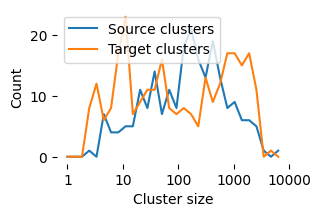

In [15]:
prefix = "src_tgt_group_sizes"

h5 = h5_m; fn = fn_summary_microns
# h5 = h5_s; fn = fn_summary_sscx
data = read_data_instances(h5, fn, prefix)

def remove_filler_group(_data):
    _data = _data.loc[~numpy.isnan(_data)]
    nz = numpy.nonzero(numpy.diff(_data.index.values) > 1)[0]
    return _data.iloc[numpy.setdiff1d(range(len(_data)), nz + 1)]

data = [_data.apply(remove_filler_group, axis=0) for _data in data]
data = pandas.concat(data, axis=0, keys=range(len(data)), names=["Instance"])

bins = numpy.linspace(0, numpy.log10(8500), 31)

fig = plt.figure(figsize=(3, 2))
ax = fig.gca()

ax.plot(bins[:-1], numpy.histogram(numpy.log10(data["src_grp"].values), bins=bins)[0],
       label="Source clusters")
ax.plot(bins[:-1], numpy.histogram(numpy.log10(data["tgt_grp"].values), bins=bins)[0],
       label="Target clusters")
plt.legend()
ax.set_frame_on(False)
ax.set_xlabel("Cluster size")
ax.set_ylabel("Count")
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(10**plt.gca().get_xticks())

fig.savefig("cluster_sizes.pdf")